In [106]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

import pandas as pd
import numpy as np

from tigramite.models import Models, Prediction

import math
import sklearn
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'tqdm'

In [35]:
def select_links(tau_min, tau_max, parents, children):
    """
    This function selects the causal links that will be tested by
    PCMCI. The links are selected such that per each variable in
    `children` all `parents` are stablished as causes, and no other
    causal relationships exist.
    
    Assumes `parents` and `children` are disjoint sets, and that all
    variables are included in the union of both sets.
    
    Parameters
    ----------
    tau_min : int
        Minimum time lag to test. Note that zero-lags are undirected.
    tau_max : int
        Maximum time lag. Must be larger or equal to tau_min.
    parents : set of int
        List of variables that will be assigned as a parent link.
        Assumed to be disjoint with children
    children : set of int
        List of variables that will be assigned a link from a parent.
        Assumed to be disjoint with parents
    Returns
    -------
    selected_links: dict
        Dictionary of selected links for Tigramite
        
    """

    parents = set(parents)
    children = set(children)

    selected_links = dict()
    # Set the default as all combinations of the selected variables
    for var in [*children, *parents]:
        if var in children:
            # Children can be caused only by parents and by themselves
            selected_links[var] = [
                (parent, -lag)
                for parent in parents
                for lag in range(tau_min, tau_max + 1)
            ]
        else:
            selected_links[var] = []

    return selected_links

In [36]:
p1="../../tigramite_timeseries/"
p2="../../targets/"

In [162]:
import glob,os
glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/*halong*')

['/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/timeseries_all_wp_halong.csv']

In [164]:
glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/*halong*')[0].split('/c')[-1].split('.')[0].split('_')[-1]

'halong'

In [161]:
glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/*')

['/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_integrated_prate_nio_keila.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_integrated_prate_nwp_haima.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_integrated_prate_nwp_keila.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_integrated_prate_nwp_nalgae.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_integrated_prate_nwp_songda.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_integrated_prate_nwp_washi.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_pmin_nio_keila.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_pmin_nwp_haima.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_pmin_nwp_nalgae.csv',
 '/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/2011_pmin_nwp_songda.

In [178]:
glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/*halong*')

['/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/timeseries_all_wp_halong.csv']

In [185]:
def _process_dataset(path=None):
    df1 = pd.read_csv(path,sep=',')
    df1.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
    df1=df1.drop('a', axis=1)
    df1=df1.drop('conv_rrate', axis=1)
    df1=df1.drop('ls_rrate', axis=1)
    df1=df1.drop('mn_conv_prate', axis=1)
    df1=df1.drop('mn_ls_prate', axis=1)
    df1=df1.drop('mn_tot_prate', axis=1)
    df1=df1.drop('outconv_rrate', axis=1)
    df1=df1.drop('outls_rrate', axis=1)
    df1=df1.drop('outmn_conv_prate', axis=1)
    df1=df1.drop('outmn_ls_prate', axis=1)
    df1=df1.drop('outmn_tot_prate', axis=1)
    df1=df1.drop('conv_ppt', axis=1)
    df1=df1.drop('outconv_ppt', axis=1)
    
    TCname = path.split('/')[-1].split('.')[0].split('_')[-1]
    print(TCname)
    for item in glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/targets/*integrated_prate*'):
        if str(TCname) in item:
            d1=pd.read_csv(item)
            d1.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
            d1=d1.drop('a', axis=1)
            dt1=pd.concat([d1,df1],axis=1, join='inner')
        else:
            continue
    return dt1

In [186]:
_process_dataset(glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/*halong*')[0])

halong


,Prec_Intg,Pmin,w10max,div100,div200,div250,div300,div400,div500,eqt1000,...,outvvel_250,outvvel_300,outvvel_400,outvvel_500,outvvel_600,outvvel_700,outvvel_850,outvvel_925,outvvel_975,outvvel_1000
0,371.110123,1005.866250,15.143981,0.000069,0.000040,0.000010,-4.305039e-07,-6.350823e-07,-0.000012,337.360107,...,-0.108564,-0.114062,-0.123317,-0.133900,-0.138262,-0.119083,-0.072614,-0.046888,-0.022637,-0.009696
1,425.796825,1004.223125,16.172941,0.000047,0.000043,0.000016,2.335084e-06,5.733423e-07,-0.000006,337.119385,...,-0.100423,-0.110635,-0.133223,-0.145190,-0.138606,-0.120845,-0.074635,-0.047808,-0.024531,-0.012277
2,356.509332,1003.820000,15.827768,0.000063,0.000023,0.000003,-1.355308e-06,6.241533e-06,-0.000001,337.109131,...,-0.129423,-0.147395,-0.158625,-0.158529,-0.149433,-0.126961,-0.070797,-0.037010,-0.009722,0.003943
3,366.266761,1005.823750,16.176758,0.000067,0.000031,0.000003,-2.118941e-08,-1.781067e-07,-0.000008,337.228882,...,-0.120494,-0.134204,-0.136630,-0.128401,-0.116228,-0.096571,-0.045271,-0.017750,0.001684,0.010801
4,354.398396,1005.372500,15.577791,0.000060,0.000046,0.000010,2.464989e-06,-9.243633e-06,-0.000023,336.734650,...,-0.130604,-0.139912,-0.142980,-0.146438,-0.143460,-0.119920,-0.066747,-0.040254,-0.020157,-0.010684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,94.129723,1005.181875,13.425345,-0.000003,0.000008,0.000004,-1.362927e-06,-1.189506e-06,-0.000007,307.373383,...,-0.014155,-0.011369,-0.038234,-0.061695,-0.057427,-0.057824,-0.054236,-0.043447,-0.023468,-0.011980
62,60.461611,1005.450000,11.935371,0.000002,0.000010,-0.000012,-8.176885e-07,-5.746483e-06,0.000001,307.035858,...,-0.012953,-0.012705,-0.025993,-0.029523,-0.009855,-0.016618,-0.021508,-0.018830,-0.006638,0.001984
63,41.179899,1006.061250,11.609192,0.000011,0.000006,-0.000007,4.725619e-06,-1.023247e-05,0.000004,309.956299,...,-0.006731,0.003601,0.004681,0.019780,0.037188,0.023065,-0.015833,-0.026009,-0.015624,-0.007162
64,39.850697,1006.156875,11.154061,0.000007,-0.000003,0.000004,-2.145885e-06,-2.728699e-06,-0.000003,310.830475,...,-0.008538,0.009978,0.028379,0.049900,0.035477,0.016924,-0.004068,-0.024596,-0.014808,-0.006635


In [187]:
_process_dataset(glob.glob('/media/saranya/DAEA17D6EA17ADAF/Data/Research_2022/jun22/tigramite_timeseries/*vongfong*')[0])

vongfong


,Prec_Intg,Pmin,w10max,div100,div200,div250,div300,div400,div500,eqt1000,...,outvvel_250,outvvel_300,outvvel_400,outvvel_500,outvvel_600,outvvel_700,outvvel_850,outvvel_925,outvvel_975,outvvel_1000
0,67.389403,1006.503125,10.309203,-0.000001,-0.000005,5.563559e-06,7.814137e-06,5.854761e-06,-6.114945e-06,336.610168,...,-0.017239,-0.014685,-0.014093,-0.021459,-0.023367,-0.023218,-0.016347,-0.012411,-0.011369,-0.011921
1,114.404410,1007.219375,10.910505,0.000008,-0.000003,-3.635838e-06,-9.401367e-07,7.783531e-07,4.811327e-06,337.293274,...,-0.007932,-0.007196,-0.010029,-0.005048,0.005829,0.004892,0.009933,0.011347,0.012184,0.012573
2,119.542442,1008.651250,9.938855,0.000017,0.000018,1.688236e-06,-3.315896e-06,-8.495769e-06,2.562160e-06,336.432892,...,-0.008368,-0.011420,-0.010271,-0.021445,-0.026553,-0.031266,-0.014306,0.001209,0.013136,0.019182
3,191.726349,1009.249375,8.958860,0.000019,0.000022,6.507719e-07,-4.473000e-06,5.714251e-07,6.604291e-06,335.481506,...,-0.014817,-0.021382,-0.014912,-0.021877,-0.032610,-0.043306,-0.041707,-0.033292,-0.020583,-0.013190
4,230.251662,1007.211875,9.296708,0.000013,0.000016,-7.199931e-06,-6.999429e-06,6.906871e-06,7.085467e-06,336.512817,...,-0.016345,-0.026049,-0.023159,-0.024482,-0.030461,-0.041564,-0.040362,-0.032811,-0.018987,-0.011025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,78.484006,1001.025625,12.185334,0.000024,0.000012,8.853050e-06,3.857888e-06,-1.038136e-05,-1.042617e-05,328.694977,...,-0.061413,-0.062718,-0.049377,-0.023853,-0.011261,-0.008431,-0.008181,-0.000613,-0.000111,-0.000875
77,88.376105,1000.696875,12.407811,0.000016,-0.000004,3.084240e-06,3.603419e-06,-5.541900e-06,1.467028e-06,326.974548,...,-0.088857,-0.099130,-0.101710,-0.086532,-0.068555,-0.047266,-0.013787,0.009541,0.018420,0.021655
78,153.906085,1002.281250,12.184855,0.000025,0.000002,-2.187550e-06,2.550591e-06,-5.712461e-06,1.519241e-06,325.978271,...,-0.077323,-0.084952,-0.096958,-0.095587,-0.086664,-0.077748,-0.038221,-0.005653,0.004849,0.006095
79,179.602224,1001.694375,13.254792,0.000017,0.000002,-9.022481e-07,1.410654e-06,-4.320523e-06,-2.568056e-07,322.068451,...,-0.081520,-0.084607,-0.092742,-0.092829,-0.090708,-0.088155,-0.056129,-0.029039,-0.021095,-0.018348


In [188]:
dt1

,Prec_Intg,Pmin,w10max,div100,div200,div250,div300,div400,div500,eqt1000,...,outvvel_250,outvvel_300,outvvel_400,outvvel_500,outvvel_600,outvvel_700,outvvel_850,outvvel_925,outvvel_975,outvvel_1000
0,67.389403,1006.503125,10.309203,-0.000001,-0.000005,5.563559e-06,7.814137e-06,5.854761e-06,-6.114945e-06,336.610168,...,-0.017239,-0.014685,-0.014093,-0.021459,-0.023367,-0.023218,-0.016347,-0.012411,-0.011369,-0.011921
1,114.404410,1007.219375,10.910505,0.000008,-0.000003,-3.635838e-06,-9.401367e-07,7.783531e-07,4.811327e-06,337.293274,...,-0.007932,-0.007196,-0.010029,-0.005048,0.005829,0.004892,0.009933,0.011347,0.012184,0.012573
2,119.542442,1008.651250,9.938855,0.000017,0.000018,1.688236e-06,-3.315896e-06,-8.495769e-06,2.562160e-06,336.432892,...,-0.008368,-0.011420,-0.010271,-0.021445,-0.026553,-0.031266,-0.014306,0.001209,0.013136,0.019182
3,191.726349,1009.249375,8.958860,0.000019,0.000022,6.507719e-07,-4.473000e-06,5.714251e-07,6.604291e-06,335.481506,...,-0.014817,-0.021382,-0.014912,-0.021877,-0.032610,-0.043306,-0.041707,-0.033292,-0.020583,-0.013190
4,230.251662,1007.211875,9.296708,0.000013,0.000016,-7.199931e-06,-6.999429e-06,6.906871e-06,7.085467e-06,336.512817,...,-0.016345,-0.026049,-0.023159,-0.024482,-0.030461,-0.041564,-0.040362,-0.032811,-0.018987,-0.011025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,78.484006,1001.025625,12.185334,0.000024,0.000012,8.853050e-06,3.857888e-06,-1.038136e-05,-1.042617e-05,328.694977,...,-0.061413,-0.062718,-0.049377,-0.023853,-0.011261,-0.008431,-0.008181,-0.000613,-0.000111,-0.000875
77,88.376105,1000.696875,12.407811,0.000016,-0.000004,3.084240e-06,3.603419e-06,-5.541900e-06,1.467028e-06,326.974548,...,-0.088857,-0.099130,-0.101710,-0.086532,-0.068555,-0.047266,-0.013787,0.009541,0.018420,0.021655
78,153.906085,1002.281250,12.184855,0.000025,0.000002,-2.187550e-06,2.550591e-06,-5.712461e-06,1.519241e-06,325.978271,...,-0.077323,-0.084952,-0.096958,-0.095587,-0.086664,-0.077748,-0.038221,-0.005653,0.004849,0.006095
79,179.602224,1001.694375,13.254792,0.000017,0.000002,-9.022481e-07,1.410654e-06,-4.320523e-06,-2.568056e-07,322.068451,...,-0.081520,-0.084607,-0.092742,-0.092829,-0.090708,-0.088155,-0.056129,-0.029039,-0.021095,-0.018348


In [37]:
df1 = pd.read_csv(p1+"timeseries_all_wp_vongfong.csv",sep=',')
df1.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df1=df1.drop('a', axis=1)
df1=df1.drop('conv_rrate', axis=1)
df1=df1.drop('ls_rrate', axis=1)
df1=df1.drop('mn_conv_prate', axis=1)
df1=df1.drop('mn_ls_prate', axis=1)
df1=df1.drop('mn_tot_prate', axis=1)
df1=df1.drop('outconv_rrate', axis=1)
df1=df1.drop('outls_rrate', axis=1)
df1=df1.drop('outmn_conv_prate', axis=1)
df1=df1.drop('outmn_ls_prate', axis=1)
df1=df1.drop('outmn_tot_prate', axis=1)
df1=df1.drop('conv_ppt', axis=1)
df1=df1.drop('outconv_ppt', axis=1)
d1=pd.read_csv(p2+'2020_integrated_prate_nwp_vongfong.csv')
d1.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d1=d1.drop('a', axis=1)
dt1=pd.concat([d1,df1],axis=1, join='inner')

In [38]:
df2 = pd.read_csv(p1+"timeseries_all_wp_chanhom.csv",sep=',')
df2.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df2=df2.drop('a', axis=1)
df2=df2.drop('conv_rrate', axis=1)
df2=df2.drop('ls_rrate', axis=1)
df2=df2.drop('mn_conv_prate', axis=1)
df2=df2.drop('mn_ls_prate', axis=1)
df2=df2.drop('mn_tot_prate', axis=1)
df2=df2.drop('outconv_rrate', axis=1)
df2=df2.drop('outls_rrate', axis=1)
df2=df2.drop('outmn_conv_prate', axis=1)
df2=df2.drop('outmn_ls_prate', axis=1)
df2=df2.drop('outmn_tot_prate', axis=1)
df2=df2.drop('conv_ppt', axis=1)
df2=df2.drop('outconv_ppt', axis=1)
d2=pd.read_csv(p2+'2020_integrated_prate_nwp_chanhom.csv')
d2.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d2=d2.drop('a', axis=1)
dt2=pd.concat([d2,df2],axis=1, join='inner')

In [39]:
df3 = pd.read_csv(p1+"timeseries_all_wp_saudel.csv",sep=',')
df3.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df3=df3.drop('a', axis=1)
df3=df3.drop('conv_rrate', axis=1)
df3=df3.drop('ls_rrate', axis=1)
df3=df3.drop('mn_conv_prate', axis=1)
df3=df3.drop('mn_ls_prate', axis=1)
df3=df3.drop('mn_tot_prate', axis=1)
df3=df3.drop('outconv_rrate', axis=1)
df3=df3.drop('outls_rrate', axis=1)
df3=df3.drop('outmn_conv_prate', axis=1)
df3=df3.drop('outmn_ls_prate', axis=1)
df3=df3.drop('outmn_tot_prate', axis=1)
df3=df3.drop('conv_ppt', axis=1)
df3=df3.drop('outconv_ppt', axis=1)
d3=pd.read_csv(p2+'2020_integrated_prate_nwp_saudel.csv')
d3.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d3=d3.drop('a', axis=1)
dt3=pd.concat([d3,df3],axis=1, join='inner')

In [40]:
df4 = pd.read_csv(p1+"timeseries_all_wp_molave.csv",sep=',')
df4.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df4=df4.drop('a', axis=1)
df4=df4.drop('conv_rrate', axis=1)
df4=df4.drop('ls_rrate', axis=1)
df4=df4.drop('mn_conv_prate', axis=1)
df4=df4.drop('mn_ls_prate', axis=1)
df4=df4.drop('mn_tot_prate', axis=1)
df4=df4.drop('outconv_rrate', axis=1)
df4=df4.drop('outls_rrate', axis=1)
df4=df4.drop('outmn_conv_prate', axis=1)
df4=df4.drop('outmn_ls_prate', axis=1)
df4=df4.drop('outmn_tot_prate', axis=1)
df4=df4.drop('conv_ppt', axis=1)
df4=df4.drop('outconv_ppt', axis=1)
d4=pd.read_csv(p2+'2020_integrated_prate_nwp_molave.csv')
d4.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d4=d4.drop('a', axis=1)
dt4=pd.concat([d4,df4],axis=1, join='inner')

In [41]:
df6 = pd.read_csv(p1+"timeseries_all_amphan.csv",sep=',')
df6.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df6=df6.drop('a', axis=1)
df6=df6.drop('conv_rrate', axis=1)
df6=df6.drop('ls_rrate', axis=1)
df6=df6.drop('mn_conv_prate', axis=1)
df6=df6.drop('mn_ls_prate', axis=1)
df6=df6.drop('mn_tot_prate', axis=1)
df6=df6.drop('outconv_rrate', axis=1)
df6=df6.drop('outls_rrate', axis=1)
df6=df6.drop('outmn_conv_prate', axis=1)
df6=df6.drop('outmn_ls_prate', axis=1)
df6=df6.drop('outmn_tot_prate', axis=1)
df6=df6.drop('conv_ppt', axis=1)
df6=df6.drop('outconv_ppt', axis=1)
d6=pd.read_csv(p2+'2020_integrated_prate_nio_amphan.csv')
d6.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d6=d6.drop('a', axis=1)
dt6=pd.concat([d6,df6],axis=1, join='inner')

In [42]:
df7 = pd.read_csv(p1+"timeseries_all_nio_kyaar.csv",sep=',')
df7.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df7=df7.drop('a', axis=1)
df7=df7.drop('conv_rrate', axis=1)
df7=df7.drop('ls_rrate', axis=1)
df7=df7.drop('mn_conv_prate', axis=1)
df7=df7.drop('mn_ls_prate', axis=1)
df7=df7.drop('mn_tot_prate', axis=1)
df7=df7.drop('outconv_rrate', axis=1)
df7=df7.drop('outls_rrate', axis=1)
df7=df7.drop('outmn_conv_prate', axis=1)
df7=df7.drop('outmn_ls_prate', axis=1)
df7=df7.drop('outmn_tot_prate', axis=1)
df7=df7.drop('conv_ppt', axis=1)
df7=df7.drop('outconv_ppt', axis=1)
d7=pd.read_csv(p2+'2019_integrated_prate_nio_kyaar.csv')
d7.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d7=d7.drop('a', axis=1)
dt7=pd.concat([d7,df7],axis=1, join='inner')

In [43]:
df8 = pd.read_csv(p1+"timeseries_all_nio_pawan.csv",sep=',')
df8.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df8=df8.drop('a', axis=1)
df8=df8.drop('conv_rrate', axis=1)
df8=df8.drop('ls_rrate', axis=1)
df8=df8.drop('mn_conv_prate', axis=1)
df8=df8.drop('mn_ls_prate', axis=1)
df8=df8.drop('mn_tot_prate', axis=1)
df8=df8.drop('outconv_rrate', axis=1)
df8=df8.drop('outls_rrate', axis=1)
df8=df8.drop('outmn_conv_prate', axis=1)
df8=df8.drop('outmn_ls_prate', axis=1)
df8=df8.drop('outmn_tot_prate', axis=1)
df8=df8.drop('conv_ppt', axis=1)
df8=df8.drop('outconv_ppt', axis=1)
d8=pd.read_csv(p2+'2019_integrated_prate_nio_pawan.csv')
d8.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d8=d8.drop('a', axis=1)
dt8=pd.concat([d8,df8],axis=1, join='inner')

In [44]:
df9 = pd.read_csv(p1+"timeseries_all_nio_maha.csv",sep=',')
df9.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df9=df9.drop('a', axis=1)
df9=df9.drop('conv_rrate', axis=1)
df9=df9.drop('ls_rrate', axis=1)
df9=df9.drop('mn_conv_prate', axis=1)
df9=df9.drop('mn_ls_prate', axis=1)
df9=df9.drop('mn_tot_prate', axis=1)
df9=df9.drop('outconv_rrate', axis=1)
df9=df9.drop('outls_rrate', axis=1)
df9=df9.drop('outmn_conv_prate', axis=1)
df9=df9.drop('outmn_ls_prate', axis=1)
df9=df9.drop('outmn_tot_prate', axis=1)
df9=df9.drop('conv_ppt', axis=1)
df9=df9.drop('outconv_ppt', axis=1)
d9=pd.read_csv(p2+'2019_integrated_prate_nio_maha.csv')
d9.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
d9=d9.drop('a', axis=1)
dt9=pd.concat([d9,df9],axis=1, join='inner')

In [61]:
tc1=dt1.values
tc2=dt2.values
tc3=dt3.values
tc4=dt4.values

tc6=dt6.values
tc7=dt7.values
tc8=dt8.values
tc9=dt9.values


In [62]:
var_names=dt1.columns.values.tolist()

In [63]:
var_names

['Prec_Intg',
 'Pmin',
 'w10max',
 'div100',
 'div200',
 'div250',
 'div300',
 'div400',
 'div500',
 'eqt1000',
 'eqt200',
 'eqt250',
 'eqt300',
 'eqt400',
 'eqt500',
 'eqt600',
 'eqt700',
 'eqt850',
 'eqt925',
 'sh850_200',
 'sh850_250',
 'sh925_200',
 'sh925_250',
 'wstrss10',
 '2mdewtmp',
 '2mtmp',
 'tot_cld_ice',
 'tot_cldwtr',
 'tot_cld_rain',
 'vi_div_cld_froz_wtr',
 'vi_div_cld_liq_wtr',
 'vi_div_mass_flux',
 'vi_div_moisture_flux',
 'vi_div_tot_enrgy_flux',
 'vi_pe_inte',
 'vi_pe_ie_latentenrgy',
 'vi_olr',
 'vi_tot_enrgy',
 'vi_moisture_div',
 'cape',
 'inst_moisture_flux',
 'inst_ssh_flux',
 'surfmean_lhf',
 'surfmean_shf',
 'vimean_moisture_div',
 'surf_lhf',
 'surf_shf',
 'tot_suprcool_liqwtr',
 'tot_wtr_vpr',
 'sst',
 'vort_10',
 'vort_20',
 'vort_30',
 'vort_50',
 'vort_70',
 'vort_100',
 'vort_150',
 'vort_200',
 'vort_250',
 'vort_300',
 'vort_400',
 'vort_500',
 'vort_600',
 'vort_700',
 'vort_800',
 'vort_850',
 'vort_900',
 'vort_925',
 'vort_950',
 'vort_975',
 'vor

In [64]:
dd={'cyclone1':tc1,'cyclone2':tc2,'cyclone3':tc3,'cyclone4':tc4,'cyclone5':tc6,'cyclone6':tc7,'cyclone7':tc8,
   'cyclone8':tc9  }

#### Randomly remove 1 storm

In [65]:
from numpy.random import default_rng

rng = default_rng(12345)
seed = rng.choice(8, 1, replace=False)

In [66]:
'cyclone'+str(int(seed))

'cyclone5'

In [67]:
data=dd.copy()
del data['cyclone'+str(int(seed))]

In [68]:
dataframe = pp.DataFrame(data,analysis_mode ='multiple', var_names=var_names)
tau_max0 = 16
tau_min0 = 1

for member in dataframe.values.keys():
    children = [0,1,2]
    parents = np.arange(3,259)
    sel_links = select_links(tau_min0, tau_max0, parents, children)

In [20]:
pc_alpha = 0.01
pcmci = PCMCI(dataframe = dataframe, cond_ind_test = ParCorr())
results = pcmci.run_pcmci(selected_links = sel_links, tau_min = tau_min0, tau_max = tau_max0,  pc_alpha = pc_alpha)


In [21]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],selected_links = sel_links, tau_min=tau_min0,tau_max=tau_max0, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)
#graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.05,
#                                     tau_min=tau_min0,tau_max=tau_max0, selected_links=sel_links)
#results['graph'] = graph

# Plot time series graph
#tp.plot_time_series_graph(
#    figsize=(6, 3),
#     node_aspect=2.,
#    val_matrix=np.ones(graph.shape),
#    graph=graph,
#    var_names=None,
#    link_colorbar_label='',
#    ); plt.show()


## Significant links at alpha = 0.05:

    Variable Prec_Intg has 422 link(s):
        (outtot_cld_rain -1): pval = 0.00000 | val =  0.470
        (vvel_600 -1): pval = 0.00000 | val = -0.469
        (vort_100 -1): pval = 0.00000 | val =  0.441
        (outvvel_500 -1): pval = 0.00000 | val = -0.322
        (outtot_cld_ice -1): pval = 0.00000 | val =  0.320
        (outvvel_600 -1): pval = 0.00000 | val = -0.314
        (out_eqt850 -6): pval = 0.00000 | val =  0.312
        (out_div400 -1): pval = 0.00000 | val =  0.302
        (outvvel_200 -16): pval = 0.00001 | val =  0.279
        (out_div250 -7): pval = 0.00004 | val =  0.269
        (outvvel_150 -15): pval = 0.00004 | val =  0.268
        (outvvel_700 -1): pval = 0.00005 | val = -0.266
        (outvvel_150 -16): pval = 0.00005 | val =  0.265
        (tot_cld_rain -6): pval = 0.00029 | val = -0.243
        (rhum_1000 -16): pval = 0.00029 | val =  0.242
        (out_div250 -6): pval = 0.00033 | val =  0.240
        (out_div100 -16)

In [70]:
sig_links = (q_matrix.copy() <= 0.05)
arr = []
for j in range(3):
    links = {(p[0], -p[1]): np.abs(results['val_matrix'][p[0], j, abs(p[1])]) for p in zip(*np.where(sig_links[:, j, :]))}
    # Sort by value
    sorted_links = sorted(links, key=links.get, reverse=True)
    arr.append(sorted_links)

#### Extract variables and lag information

In [104]:
len(arr[0])

422

In [72]:
#filtvarindex = {'precip':sorted(list(set(obj[0] for obj in arr[0]))),\
#                'pmin':sorted(list(set(obj[0] for obj in arr[1]))),\
#                '10wspd':sorted(list(set(obj[0] for obj in arr[2])))}
filtvar_lag_dict = {'precip':[obj for obj in arr[0]],\
                    'pmin':[obj for obj in arr[1]],\
                   '10wspd':[obj for obj in arr[2]]}

In [78]:

data['cyclone1'][:(filtvar_lag_dict['precip'][0][1]),156]

array([0.01602166, 0.01646996, 0.0206255 , 0.03346259, 0.04662046,
       0.04634654, 0.02408053, 0.01397228, 0.01491111, 0.02407614,
       0.02368177, 0.03442036, 0.04766599, 0.05906334, 0.08540045,
       0.10599098, 0.12543761, 0.12139301, 0.0737608 , 0.05125052,
       0.02542992, 0.01840909, 0.01610788, 0.01974525, 0.01987464,
       0.01850446, 0.01682129, 0.01493174, 0.01982585, 0.03260581,
       0.02519143, 0.01372967, 0.0116464 , 0.00692698, 0.00378462,
       0.00426407, 0.00904172, 0.00973447, 0.00680046, 0.00681906,
       0.00810528, 0.00646979, 0.00342528, 0.00338809, 0.00384294,
       0.00384591, 0.00236219, 0.00482553, 0.0047624 , 0.00668557,
       0.00624483, 0.00614478, 0.00763378, 0.00917241, 0.0054863 ,
       0.01379989, 0.01314596, 0.01095225, 0.00629012, 0.00626698,
       0.00444031, 0.00707525, 0.0065731 , 0.00863654, 0.0131279 ,
       0.0132541 , 0.01338469, 0.01703943, 0.01457512, 0.02155724,
       0.02453073, 0.03395418, 0.02701791, 0.01891848, 0.02548

In [151]:
# Extract lag info
def extract_lag_info(datar=None,varindex=None,lag=None):
    temp = datar[:,varindex] # Full time series
    store = []
    for timeindex in range(len(temp)):
        if timeindex < np.abs(lag):
            store.append(np.nan)
        elif timeindex > len(temp)-1-np.abs(lag):
            store.append(np.nan)
        else:
            store.append(temp[timeindex-np.abs(lag)])
    return store

In [152]:
varindexstore,lagstore,TS_store = [],[],[]
for varindex,lag in arr[0]:
    varindexstore.append(varindex)
    lagstore.append(lag)
    TS_store.append([extract_lag_info(datar=data[obj],varindex=varindex,lag=lag) for obj in data.keys()])

In [153]:
X_withnan_store = []
for varindex in range(len(TS_store)):
    tempp = np.concatenate([(obj-np.nanmean(obj))/np.nanstd(obj) for obj in TS_store[varindex]])
    X_withnan_store.append((tempp-np.nanmean(tempp))/np.nanstd(tempp))

In [154]:
Ytemp = np.concatenate([data[obj][:,0] for obj in data.keys()])

In [155]:
X_nonan,Y_nonan = [],[]
X_withnan_storer = np.asarray(X_withnan_store).transpose()
for i in (range(len(Ytemp))):
    tempX = X_withnan_storer[i,:]
    if np.isnan(tempX).any():
        continue
    else:
        X_nonan.append(tempX)
        Y_nonan.append(Ytemp[i])

##### test set

In [156]:
TStest_store = []
for varindex,lag in arr[0]:
    TStest_store.append(extract_lag_info(datar=dd['cyclone5'],varindex=varindex,lag=lag))

Xtest_withnan_store = []
for varindex in range(len(TStest_store)):
    Xtest_withnan_store.append((TStest_store[varindex]-np.nanmean(TStest_store[varindex]))/np.nanstd(TStest_store[varindex]))

Xtest_nonan,ytest_nonan = [],[]
Xtest_withnan_storer = np.asarray(Xtest_withnan_store).transpose()
for i in (range(len(Xtest_withnan_storer))):
    tempX = Xtest_withnan_storer[i,:]
    if np.isnan(tempX).any():
        continue
    else:
        Xtest_nonan.append(tempX)
        ytest_nonan.append(dd['cyclone5'][:,0][i])

In [157]:
regr = LinearRegression()
regr.fit(X_nonan,Y_nonan)

LinearRegression()

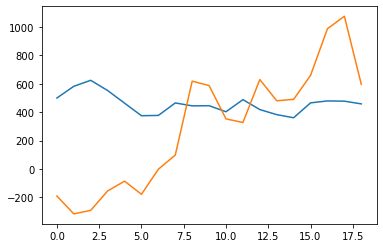

In [158]:
plt.plot(ytest_nonan)
plt.plot(regr.predict(Xtest_nonan))
plt.show()

In [ ]:
dd['cyclone5'][:,0]

In [26]:
class Pipeline:
    """
    Linear Regression Pipeline
    """
    def __init__(self,data,pc_alpha,pc_type='run_pcstable' or 'pcmci',pcmci_results=None,target='precip',seed=None):
        self.pc_alpha = pc_alpha
        self.data = data
        self.pc_type = pc_type
        self.target = target
        self.pcmci_results = pcmci_results
        
    def flatten_array(self,index=None,normalize=True):
        """
        Get concatenated time series
        index: variable index to extract
        """
        if normalize is True:
            temp = np.concatenate([self.data[obj][:,int(self.pcmci_results[self.target][index])] 
                                   for obj in self.data.keys()])
            return (temp-np.nanmean(temp))/np.nanstd(temp)
        else:
            return np.concatenate([self.data[obj][:,int(self.pcmci_results[self.target][index])] 
                                   for obj in self.data.keys()])
    
    def get_INPUTtimeseries(self):
        storeresults = []
        for ind,obj in enumerate(range(len(self.pcmci_results[self.target]))):
            storeresults.append(self.flatten_array(obj,True))
        return np.transpose(np.asarray(storeresults))
    
    def get_OUTPUTtimeseries(self):
        if self.target=='precip':
            return np.concatenate([self.data[obj][:,0] for obj in self.data.keys()])
        elif self.target=='pmin':
            return np.concatenate([self.data[obj][:,1] for obj in self.data.keys()])
        elif self.target=='10wspd':
            return np.concatenate([self.data[obj][:,2] for obj in self.data.keys()])
    
    def fit_transform(self,Xdata=None):
        storeresults = []
        for ind,obj in enumerate(range(len(self.pcmci_results[self.target]))):
            temp = Xdata[:,int(self.pcmci_results[self.target][obj])]
            tempn = (temp-np.nanmean(temp))/np.nanstd(temp)
            storeresults.append(tempn)
        return np.transpose(np.asarray(storeresults))
        
    def fit_model(self,X=None,y=None):
        regr = LinearRegression()
        return regr.fit(X,y)

In [27]:
Xtest = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').fit_transform(dd['cyclone5'])

In [28]:
Xtrain = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').get_INPUTtimeseries()
ytrain = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').get_OUTPUTtimeseries()

In [29]:
linrgr_model1 = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').fit_model(Xtrain,ytrain)

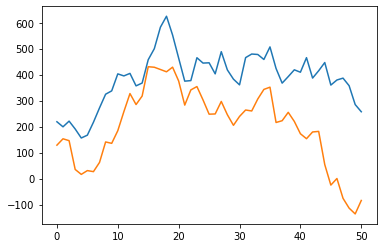

In [30]:
plt.plot(dd['cyclone5'][:,0])
plt.plot(linrgr_model1.predict(Xtest))
plt.show()

In [31]:
linrgr_model1.predict(Xtest)

array([ 1.28584353e+02,  1.53041682e+02,  1.45891942e+02,  3.50803842e+01,
        1.60984918e+01,  3.06343081e+01,  2.66274703e+01,  6.22203689e+01,
        1.40894362e+02,  1.35567858e+02,  1.84230191e+02,  2.57586866e+02,
        3.27132460e+02,  2.84872877e+02,  3.17569810e+02,  4.30393735e+02,
        4.28465906e+02,  4.19772240e+02,  4.10910153e+02,  4.28749714e+02,
        3.75454383e+02,  2.82737267e+02,  3.41173805e+02,  3.54084746e+02,
        3.02736517e+02,  2.47784059e+02,  2.48657593e+02,  2.96780378e+02,
        2.45765653e+02,  2.04928701e+02,  2.39148032e+02,  2.63876745e+02,
        2.60119963e+02,  3.06402951e+02,  3.43092440e+02,  3.51736929e+02,
        2.15816492e+02,  2.22634894e+02,  2.54881951e+02,  2.19892251e+02,
        1.72480541e+02,  1.53408524e+02,  1.79352039e+02,  1.81480482e+02,
        5.37900110e+01, -2.51606202e+01,  2.29200648e-01, -7.59912237e+01,
       -1.13781398e+02, -1.36085031e+02, -8.43332884e+01])

In [32]:
del datac['cyclone5']

NameError: name 'datac' is not defined

In [33]:
np.asarray([dd[obj].shape[0] for obj in dd.keys()]).cumsum()[-1]

638